Sayısal sütunlar: Index(['temp', 'feelslike', 'dew', 'humidity', 'precip', 'windspeedmean',
       'sealevelpressure', 'cloudcover', 'BarajDoluluk', 'dakika'],
      dtype='object')


<ipython-input-17-bfee032d6d69>:157: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 1/3, Train Loss: 0.04059225077313992, Test Loss: 0.0026852420613929433
Train MSE: 0.040839492551097416, Test MSE: 0.0027456118760226136
Train MAPE: 39.388614892959595%, Test MAPE: inf%
Train MAE: 0.14059785231969602, Test MAE: 0.041639757175476126
Train RMSE: 0.2020878337532901, Test RMSE: 0.05239858658420677
Train R²: 0.3444436243349649, Test R²: 0.9507989022770849
Training time for epoch 1: 50.26 seconds
Inference time for epoch 1: 0.48 seconds


<ipython-input-17-bfee032d6d69>:157: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 2/3, Train Loss: 0.0006406985568766551, Test Loss: 0.0007963207926398976
Train MSE: 0.0006437634536917505, Test MSE: 0.0006783782348460606
Train MAPE: 5.195058137178421%, Test MAPE: inf%
Train MAE: 0.01870235830801519, Test MAE: 0.01799336899167452
Train RMSE: 0.02537249403767297, Test RMSE: 0.02604569513079005
Train R²: 0.9896662957807386, Test R²: 0.9878435280247583
Training time for epoch 2: 11.17 seconds
Inference time for epoch 2: 0.49 seconds


<ipython-input-17-bfee032d6d69>:157: RuntimeWarning: divide by zero encountered in divide
  test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)


Epoch 3/3, Train Loss: 0.0003776168821921736, Test Loss: 0.0006987514544131333
Train MSE: 0.00037896947443803177, Test MSE: 0.0006199488928098163
Train MAPE: 3.552989661693573%, Test MAPE: inf%
Train MAE: 0.01412735953319361, Test MAE: 0.018399187069163363
Train RMSE: 0.01946713832174703, Test RMSE: 0.02489877291775272
Train R²: 0.9939167741900945, Test R²: 0.9888905761499928
Training time for epoch 3: 13.34 seconds
Inference time for epoch 3: 0.48 seconds


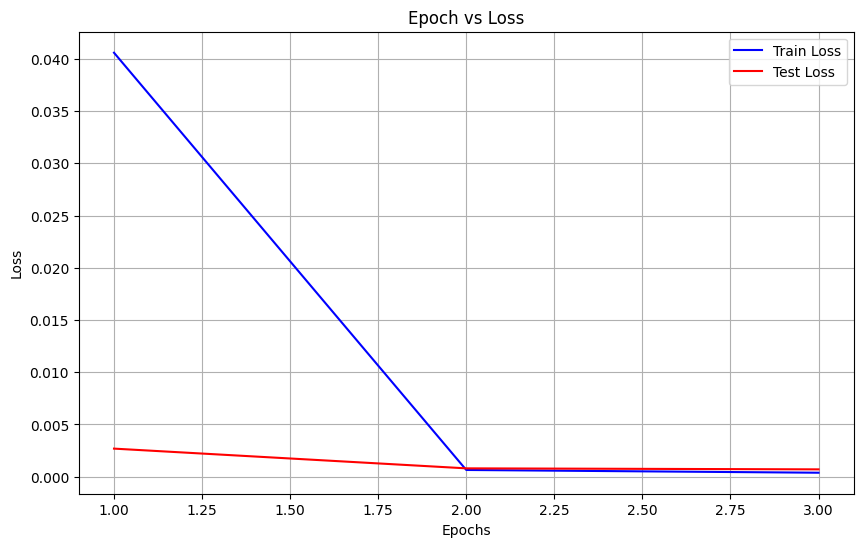

Tahminler ve gerçek değerler Excel dosyasına kaydedildi.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Veriyi yükleme
file_path = "büyükçekmecekullan.xlsx"  # Excel dosyasının yolunu girin
data = pd.read_excel(file_path)

# Tarih sütununu datetime formatına çevirme
data['Tarih'] = pd.to_datetime(data['Tarih'])
data.set_index('Tarih', inplace=True)

# Sadece sayısal sütunları seçme
numeric_columns = data.select_dtypes(include=["float64", "int64"]).columns
print("Sayısal sütunlar:", numeric_columns)  # Hangi sütunların seçildiğini kontrol edebilirsiniz

# Normalizasyon (0-1 aralığına getirme)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[numeric_columns])

# Ölçeklenmiş veriyi DataFrame formatına geri dönüştürme
scaled_data = pd.DataFrame(scaled_data, columns=numeric_columns, index=data.index)

# Veriyi eğitim ve test olarak ayırma
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Pencereleme (windowing) fonksiyonu
def create_sequences(data, target_index, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, :])
        y.append(data[i+seq_length, target_index])
    return np.array(X), np.array(y)

# Modelin tahmin edeceği hedef sütun
if "BarajDoluluk" in scaled_data.columns:
    target_index = list(scaled_data.columns).index("BarajDoluluk")
else:
    raise ValueError("Hedef sütun 'BarajDoluluk' veri kümesinde bulunamadı!")

seq_length = 365

# Pencereleme
X_train, y_train = create_sequences(train_data.values, target_index, seq_length)
X_test, y_test = create_sequences(test_data.values, target_index, seq_length)

# Torch veri seti ve veri yükleyiciler
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

# Dataset ve DataLoader
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Basit bir ETSFormer modeli (örnek olarak LSTM temelli)
class SimpleETSFormer(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleETSFormer, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        output = self.fc(lstm_out[:, -1, :])
        return output

# Model parametreleri
input_dim = len(numeric_columns)  # Özellik sayısı
hidden_dim = 64
output_dim = 1  # Baraj doluluk yüzdesi

model = SimpleETSFormer(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Eğitim ve test kayıplarını saklamak için listeler
train_losses = []
test_losses = []

# Eğitim ve test metriklerini saklamak için listeler
train_mse, train_mape, train_mae, train_rmse, train_r2 = [], [], [], [], []
test_mse, test_mape, test_mae, test_rmse, test_r2 = [], [], [], [], []

# Model eğitimi ve değerlendirme
epochs = 3
for epoch in range(epochs):
    start_train_time = time.time()  # Eğitim başlangıç zamanı
    model.train()
    train_loss = 0
    train_preds = []
    train_actuals = []

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch).squeeze()
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_preds.extend(predictions.cpu().detach().numpy())
        train_actuals.extend(y_batch.cpu().detach().numpy())

    # Eğitim süresi
    train_time = time.time() - start_train_time

    # Eğitim metriklerini hesapla
    train_mse.append(mean_squared_error(train_actuals, train_preds))
    train_mape.append(np.mean(np.abs((np.array(train_actuals) - np.array(train_preds)) / np.array(train_actuals))) * 100)
    train_mae.append(mean_absolute_error(train_actuals, train_preds))
    train_rmse.append(np.sqrt(mean_squared_error(train_actuals, train_preds)))
    train_r2.append(r2_score(train_actuals, train_preds))

    # Eğitim kaybını kaydetme
    train_losses.append(train_loss / len(train_loader))

    # Test değerlendirme
    start_test_time = time.time()  # Test başlangıç zamanı
    model.eval()
    test_loss = 0
    test_preds = []
    test_actuals = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions = model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            test_loss += loss.item()

            test_preds.extend(predictions.cpu().detach().numpy())
            test_actuals.extend(y_batch.cpu().detach().numpy())

    # Test süresi
    test_time = time.time() - start_test_time

    # Test metriklerini hesapla
    test_mse.append(mean_squared_error(test_actuals, test_preds))
    test_mape.append(np.mean(np.abs((np.array(test_actuals) - np.array(test_preds)) / np.array(test_actuals))) * 100)
    test_mae.append(mean_absolute_error(test_actuals, test_preds))
    test_rmse.append(np.sqrt(mean_squared_error(test_actuals, test_preds)))
    test_r2.append(r2_score(test_actuals, test_preds))

    # Test kaybını kaydetme
    test_losses.append(test_loss / len(test_loader))

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]}, Test Loss: {test_losses[-1]}")
    print(f"Train MSE: {train_mse[-1]}, Test MSE: {test_mse[-1]}")
    print(f"Train MAPE: {train_mape[-1]}%, Test MAPE: {test_mape[-1]}%")
    print(f"Train MAE: {train_mae[-1]}, Test MAE: {test_mae[-1]}")
    print(f"Train RMSE: {train_rmse[-1]}, Test RMSE: {test_rmse[-1]}")
    print(f"Train R²: {train_r2[-1]}, Test R²: {test_r2[-1]}")
    print(f"Training time for epoch {epoch+1}: {train_time:.2f} seconds")
    print(f"Inference time for epoch {epoch+1}: {test_time:.2f} seconds")

# Kayıpların grafiğini çizme
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs+1), train_losses, label="Train Loss", color='blue')
plt.plot(range(1, epochs+1), test_losses, label="Test Loss", color='red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epoch vs Loss")
plt.legend()
plt.grid(True)
plt.show()

# Eğitim ve test tahminlerini birleştirme
train_results = pd.DataFrame({
    'Gerçek Değer': train_actuals,
    'Tahmin': train_preds
})

test_results = pd.DataFrame({
    'Gerçek Değer': test_actuals,
    'Tahmin': test_preds
})

# Verileri Excel dosyasına kaydetme
with pd.ExcelWriter("tahminler_ve_gercekler.xlsx") as writer:
    train_results.to_excel(writer, sheet_name="Eğitim", index=False)
    test_results.to_excel(writer, sheet_name="Test", index=False)

print("Tahminler ve gerçek değerler Excel dosyasına kaydedildi.")
